# Collecting single-cell evidence for a target

1. Select datasets of interest from cell-level metadata (data from disease-relevant tissue, healthy or matched disease)
2. Get single-cell expression data for a target gene (or list of target genes) from cellxgene census 
3. Pseudo-bulk by donor
4. Run DE analysis

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
# help(cellxgene_census)
# help(cellxgene_census.get_anndata)

In [4]:
import scipy
import anndata

In [15]:
import obonet

obo_file = "data/cl.obo"  # downloaded from http://obofoundry.org/ontology/cl.html

# Load the ontology from the OBO file
graph = obonet.read_obo(obo_file)

def ontology2name(o):
    return(graph.nodes.get(o)['name'])

def get_ancestors(term_id, graph, levels=3):
    ancestors = set()
    stack = [(term_id, 0)]  # Using a stack to keep track of terms and their levels

    while stack:
        current_term, current_level = stack.pop()
        ancestors.add(current_term)

        if current_level < levels:
            parents = [parent for parent in graph.successors(current_term) if parent.startswith("CL:")]
            stack.extend([(parent, current_level + 1) for parent in parents])

    return ancestors

def get_CL_ancestors(term_id, graph):
    ancestors = get_ancestors(term_id, graph)
    return list(ancestors)

def rename_cts_to_high_level(adata, graph):
    original_terms = adata.obs['cell_type_ontology_term_id'].unique().tolist()
    # Exclude VERY high level annotations (e.g. native cell)
    keep_terms = []
    for o in original_terms:
        if len(get_ancestors(o, graph)) > 5:
            keep_terms.append(o)
    
    new_terms = original_terms.copy()
    for i,term in enumerate(original_terms):
        # Check if cell_type ontology term is the most high level in dataset  
        upstream_CL = get_CL_ancestors(term, graph)
        parent_terms = np.intersect1d(upstream_CL, keep_terms)
        if len(parent_terms) > 0:
            new_terms[i] = parent_terms[0]
    ct_rename_dict = dict(zip(original_terms, new_terms))
    
    # Rename to higher level if it exists
    while any([ct_rename_dict[v] != v for v in ct_rename_dict.values()]):
        for k,v in ct_rename_dict.items():
            if ct_rename_dict[v] != v:
                ct_rename_dict[k] = ct_rename_dict[v]
                
    adata.obs['high_level_cell_type_ontology_term_id'] = [ct_rename_dict[x] for x in adata.obs['cell_type_ontology_term_id']]
    return(ct_rename_dict)

# ct_rename_dict = rename_cts_to_high_level(adata, graph)

R plotting setup

In [5]:
## r2py setup
# import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython

In [7]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


## Load target and scdatasets data

In [8]:
data_disease = pd.read_csv('./data/association_scores_individual_drugs_data_by_indication.csv', index_col=0)
cxg_metadata = pd.read_csv('/home/jovyan/mount/gdrive/sc_targetID/data/cellxgene_hsapiens_donor_metadata.disease_relevant_annotation.csv', index_col=0)

## Load target data
targets = pd.read_csv('./data/TargetDiseasePairs_OpenTargets_cellXgeneID_12072023.csv', index_col=0)

### Compare drug target genes with all targets

In [49]:
# import genomic_features as gf
# ensdb = gf.ensembl.annotation(species="Hsapiens", version="108")
# genes = ensdb.genes()

# all_targets = pd.read_table('./data/MONDO_0002492-associated-diseases.tsv')
# genes_ids = genes.loc[genes['gene_name'].isin(all_targets.symbol), ['gene_id', 'gene_name']]
# genes_ids.columns = ['targetId', 'symbol']

# all_targets = pd.merge(all_targets, genes_ids, on='symbol')
# all_targets['diseaseId'] = 'MONDO_0002492'
# all_targets['has_cellxgene_disease_ontology'] = True
# all_targets.to_csv('./data/all_ot_targets_MONDO_0002492.csv')

## Rename cell types to high level

In [86]:
adata.obs['high_level_cell_type_ontology_term_id'].value_counts()

CL:0000079    51307
CL:0000066    30199
CL:0000034    20642
CL:0002252    20230
CL:0000192    13607
CL:0000115     5463
CL:0000084     4214
CL:0000646     3712
CL:0000584     2681
CL:0000071     2430
CL:0002179     2076
CL:0000145     1805
CL:0000236     1636
CL:0000097     1162
CL:0002573      970
CL:0000183      965
CL:1000447      754
CL:0000651      613
CL:0000234      334
CL:0002088      225
CL:0019031      224
CL:0000003      217
CL:0000163      213
CL:0000492      158
CL:0000623      129
CL:0000232       80
CL:0000319       55
CL:0000775       42
CL:0000540       25
CL:0000155       10
CL:2000095        3
CL:0000162        2
CL:1000909        1
Name: high_level_cell_type_ontology_term_id, dtype: int64

### Diagnostic plots

In [259]:
def plot_ncells(pbulk_adata, savedir=None):
    '''Plot number of cells x donor and cell type in pseudobulk dataset'''
    pl_df = pbulk_adata.obs[['high_level_cell_type', 'sample_id', 'disease', 'n_cells']].copy()
    pl_df.loc[:,'log10_n_cells'] = np.log10(pl_df['n_cells'])

    sorted_cts = pl_df.value_counts('high_level_cell_type').index.tolist()
    pl_df['high_level_cell_type'] 

    fig_height = len(sorted_cts)

    with plt.rc_context({'figure.figsize':[7, fig_height]}):
        sns.set_context('poster')
        sns.boxplot(data=pl_df, y='high_level_cell_type', x='log10_n_cells', 
                    hue='disease', dodge=True, palette='Set1', showfliers=False)
        sns.stripplot(data=pl_df, y='high_level_cell_type', x='log10_n_cells', 
                      hue='disease', dodge=True, color='black', s=3);
        plt.legend(
          bbox_to_anchor=(1.05, 1), # relative position on x and y axis (> 1 indicates outside of axis)
          loc='upper left', # equiv to hjust/vjust in ggplot
          borderaxespad=0, # The pad between the axes and legend border, in font-size units.
          frameon=False,
          title='Disease')
        plt.xlabel("log10(# cells)");
        plt.ylabel("High level cell type");
        plt.title(f'{disease_name} ({disease_ontology_id}) - {disease_relevant_tissue}');
        if savedir is not None:
            plt.savefig(f'{savedir}/cellxgene_targets_{disease_ontology_id.replace(":","_")}.n_cells_boxplot.pdf', bbox_inches='tight')

def plot_targets_dotplot(
    pbulk_adata: anndata.AnnData,
    targets: pd.DataFrame,
    disease_ontology_id: str,
    disease_name: str,
    include_other_targets: bool = True,
    split_drug_targets_by_phase: bool = True,
    max_genes: int = 20,
    savedir=None
    ):
    '''
    Plot expression of OT target genes in pseudobulk datasets.
    '''

    ## Genes to plot ## 
    if "_" in disease_ontology_id:
        disease_ontology_id = disease_ontology_id.replace("_", ":")

    # Drug targets
    disease_targets =targets[(targets['targetId'].isin(pbulk_adata.var_names))].copy()
    disease_targets['target_name'] = pbulk_adata.var.loc[disease_targets.targetId.tolist()]['feature_name'].tolist()
    disease_drug_targets = disease_targets[disease_targets['known_drug'] > 0].copy()
    drug_target_genes = disease_targets.target_name.tolist()
    if split_drug_targets_by_phase:
        disease_drug_targets['phase_class'] = pd.cut(disease_drug_targets.known_drug, [0, 0.2, 0.7, 1, 1.1], include_lowest=False, labels = ['druggable', 'safe', 'effective', 'approved'])
        pl_target_dict = disease_drug_targets.groupby('phase_class')['target_name'].apply(list).to_dict()
    else:
        pl_target_dict = {}
        pl_target_dict['Drug targets'] = drug_target_genes

    # Other targets
    if include_other_targets:
        other_target_genes = disease_targets[disease_targets['known_drug'] == 0].target_name.tolist()
        other_target_genes = np.random.choice(other_target_genes, size=len(drug_target_genes))
        pl_target_dict['Other targets'] = other_target_genes

    if max_genes is not None:
        for cl,target_ls in pl_target_dict.items():
            if len(target_ls) > max_genes:
                pl_target_dict[cl] = np.random.choice(target_ls, max_genes)
    
    ## Plot target expression ##
    sc.set_figure_params(scanpy=True, fontsize=20)
    dpl = sc.pl.MatrixPlot(
            pbulk_adata, 
            pl_target_dict, 'high_level_cell_type', 
            gene_symbols='feature_name', 
            layer='logcounts',
        
            )

    dpl.style(cmap='magma', edge_lw=0)
    dpl.legend(title =  'Mean\nlog-normalized\nexpression')
    _ = dpl.get_axes()['mainplot_ax'].set_xlabel(f'Target genes - {disease_name} ({disease_ontology_id})',fontsize=20)
#     dpl.show()
    if savedir is not None:
        plt.savefig(f'{savedir}/cellxgene_targets_{disease_ontology_id.replace(":","_")}.target_expression.pdf', bbox_inches='tight')
        plt.savefig(f'{savedir}/cellxgene_targets_{disease_ontology_id.replace(":","_")}.target_expression.png', bbox_inches='tight')
#     else:
#         dpl.show()

In [262]:
## Load target data
targets = pd.read_csv(output_dir + 'TargetDiseasePairs_OpenTargets_cellXgeneID_12072023.csv', index_col=0)

output_dir = './data/'
disease_ontology_id = 'MONDO:0010811'

pbulk_adata = sc.read_h5ad(output_dir + f'cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_OT_targets.h5ad')

cpms = scipy.sparse.csr_matrix(pbulk_adata.X.T / pbulk_adata.obs['size_factors'].values.flatten()) * 1000000
pbulk_adata.layers['logcounts'] = np.log1p(cpms).T
pbulk_adata.obs['high_level_cell_type'] = [f'{ontology2name(x)} ({x})' for x in pbulk_adata.obs['high_level_cell_type_ontology_term_id'].tolist()]
pbulk_adata.obs['sample_id'] = ['-'.join(x[1:]) for x in pbulk_adata.obs_names.str.split("-")]

disease_relevant_tissue = cxg_metadata[cxg_metadata['disease_ontology_id'] == disease_ontology_id].disease_relevant_tissue.unique()[0]
disease_name = cxg_metadata[cxg_metadata['disease_ontology_id'] == disease_ontology_id].disease.unique()[0]

plot_targets_dotplot(pbulk_adata, targets, disease_ontology_id, disease_name, savedir = '/home/jovyan/mount/gdrive/sc_targetID/plots/')
plot_ncells(pbulk_adata, savedir = '/home/jovyan/mount/gdrive/sc_targetID/plots/')

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


In [284]:
## Genes to plot ## 
if "_" in disease_ontology_id:
    disease_ontology_id = disease_ontology_id.replace("_", ":")

# Drug targets
disease_targets = targets[(targets['targetId'].isin(pbulk_adata.var_names)) & (targets.cxg_matched_id == disease_ontology_id.replace(":", "_"))].copy()
disease_targets['target_name'] = pbulk_adata.var.loc[disease_targets.targetId.tolist()]['feature_name'].tolist()
disease_drug_targets = disease_targets[disease_targets['known_drug'] > 0].copy()
drug_target_genes = disease_targets.target_name.tolist()
if split_drug_targets_by_phase:
    disease_drug_targets['phase_class'] = pd.cut(disease_drug_targets.known_drug, [0, 0.2, 0.7, 1], include_lowest=False, labels = ['safe', 'effective', 'approved'])
    pl_target_dict = disease_drug_targets.groupby('phase_class')['target_name'].apply(list).to_dict()

In [278]:
targets.sort_values('known_drug')

,targetId-diseaseId,affected_pathway,animal_model,genetic_association,known_drug,literature,rna_expression,somatic_mutation,targetId,diseaseId,cxg_matched_id
0,ENSG00000000003-EFO_0000191,0.0,0.0,0.000000,0.000000,0.000000,0.013836,0.0,ENSG00000000003,EFO_0000191,MONDO_0007650
1351457,ENSG00000164855-EFO_1000254,0.0,0.0,0.000000,0.000000,0.000000,0.019844,0.0,ENSG00000164855,EFO_1000254,EFO_1000254
1351456,ENSG00000164855-EFO_0009749,0.0,0.0,0.055379,0.000000,0.000000,0.000000,0.0,ENSG00000164855,EFO_0009749,EFO_0009749
1351455,ENSG00000164855-EFO_0007985,0.0,0.0,0.032113,0.000000,0.000000,0.000000,0.0,ENSG00000164855,EFO_0007985,EFO_0007985
1351454,ENSG00000164855-EFO_0007937,0.0,0.0,0.148413,0.000000,0.000000,0.000000,0.0,ENSG00000164855,EFO_0007937,EFO_0007937
...,...,...,...,...,...,...,...,...,...,...,...
1116750,ENSG00000149295-MONDO_0005090,0.0,0.0,0.737061,0.999541,0.942204,0.000000,0.0,ENSG00000149295,MONDO_0005090,MONDO_0005090
456326,ENSG00000108576-EFO_0003761,0.0,0.0,0.000000,0.999564,0.000000,0.000000,0.0,ENSG00000108576,EFO_0003761,MONDO_0002009
272213,ENSG00000095303-EFO_0003843,0.0,0.0,0.000000,0.999579,0.000000,0.000000,0.0,ENSG00000095303,EFO_0003843,EFO_0003843
166533,ENSG00000073756-EFO_0003843,0.0,0.0,0.000000,0.999613,0.050154,0.000000,0.0,ENSG00000073756,EFO_0003843,EFO_0003843


In [283]:
disease_drug_targets[(disease_drug_targets.targetId == 'ENSG00000007314')]

,targetId-diseaseId,affected_pathway,animal_model,genetic_association,known_drug,literature,rna_expression,somatic_mutation,targetId,diseaseId,cxg_matched_id,target_name,phase_class
25781,ENSG00000007314-EFO_0000284,0.0,0.0,0.0,0.865457,0.0,0.0,0.0,ENSG00000007314,EFO_0000284,MONDO_0010811,SCN4A,effective


In [285]:
disease_drug_targets[['phase_class', 'known_drug']].sort_values('known_drug')

,phase_class,known_drug
925255,safe,0.121586
1780530,safe,0.121586
926203,safe,0.121586
1583625,safe,0.121586
1449646,safe,0.121586
2003627,safe,0.121586
1996051,safe,0.121586
1757094,safe,0.121586
385924,safe,0.121586
322588,safe,0.121586


In [19]:
pbulk_adata.obs[['disease', 'donor_id']].drop_duplicates().value_counts('disease')

disease
normal                       342
small cell lung carcinoma      9
dtype: int64

In [20]:
pbulk_adata.obs[['disease', 'donor_id', 'n_cells']].drop_duplicates().groupby('disease')['n_cells'].sum()

disease
normal                       1595621
small cell lung carcinoma      36041
Name: n_cells, dtype: int64

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


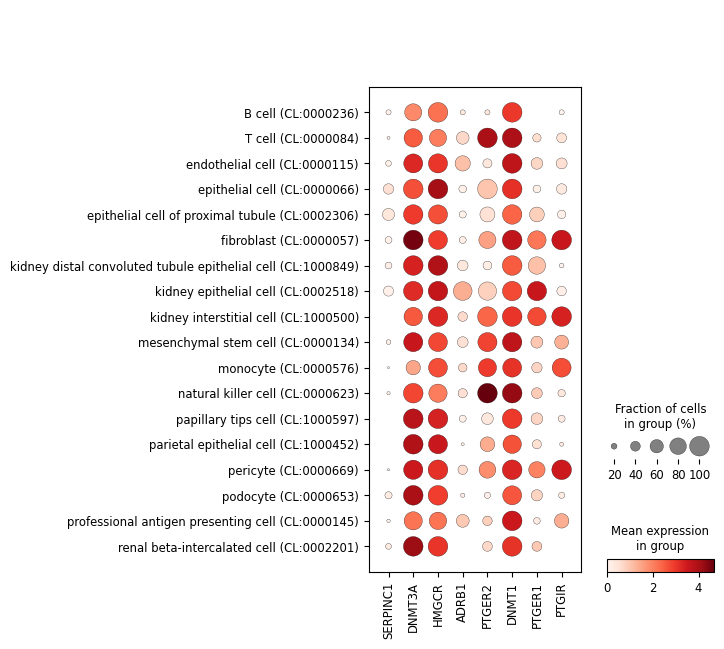

In [368]:
dpl = sc.pl.DotPlot(
    pbulk_adata, 
    pbulk_adata.var['feature_name'], 'high_level_cell_type', 
    gene_symbols='feature_name', 
    layer='logcounts',
    cmap='Reds'
)

dpl.style(cmap='magma')
dpl.show()

## Run DE analysis 
(by cell type)

In [92]:
import os

def run_glmGamPoi_DE(pbulk_adata, 
                     design = '~ disease',
                    ref_level = 'normal',
                    contrast = 'disease'
                    ):
    '''
    Run R code for DE analysis with glmGamPoi
    
    Params:
    ------
    - pbulk_adata: anndata object with pseudobulked data
    
    '''
    
    ## Define R function
    glmgampoi_str = f'''
        library(SingleCellExperiment)
        library(glmGamPoi)
        library(scran)
        library(scater)

        run_de <- function(args){{
            pbulk_sdata_X <- args[[1]]
            pbulk_sdata_obs <- args[[2]]
            pbulk_sdata_var <- args[[3]]

            sce <- SingleCellExperiment(assays = list(counts = t(pbulk_sdata_X)), colData = pbulk_sdata_obs)

            ## Fit
            fit <- glm_gp(sce, design = {design}, reference_level = '{ref_level}', size_factors = colData(sce)[['size_factors']])

            ## Test 
            de_res <- test_de(fit, contrast = '{contrast}')    
            de_res[,'gene_name'] <- pbulk_sdata_var['feature_name']
            de_res[,'gene_id'] <- pbulk_sdata_var['feature_id']
            return(de_res)
        }}'''
    
    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP
    
    ## Get anndata components
    pbulk_sdata_X = pbulk_adata.X.toarray().copy()
    pbulk_sdata_obs = pbulk_adata.obs.copy()
    pbulk_sdata_var = pbulk_adata.var.copy()
    
    r_pkg = STAP(glmgampoi_str, "r_pkg")
    # this was needed for the code to run on jhub
    # if you have a different version of rpy2 you may not need these two lines
    rpy2.robjects.pandas2ri.activate()
    rpy2.robjects.numpy2ri.activate()
    
    # PASS OBJECTS INTO FUNCTION
    args = [pbulk_sdata_X, pbulk_sdata_obs, pbulk_sdata_var]
    de_res_df = r_pkg.run_de(args).to_csvfile('./DE_results.csv')
    de_res_df = pd.read_csv('./DE_results.csv', index_col=0)
    de_res_df.index = de_res_df['gene_name']
    de_res_df.drop('name', 1, inplace=True)
    os.remove('./DE_results.csv')
    return(de_res_df)

In [93]:
n_replicates = pbulk_adata.obs.value_counts(['high_level_cell_type_ontology_term_id', 'disease']).reset_index()
ct_labels = n_replicates[n_replicates[0] >= 3]['high_level_cell_type_ontology_term_id'].unique()
pbulk_adata = pbulk_adata[pbulk_adata.obs['high_level_cell_type_ontology_term_id'].isin(ct_labels)].copy()

In [94]:
pbulk_adata.var

,soma_joinid,feature_id,feature_name,feature_length
ENSG00000117601,2497,ENSG00000117601,SERPINC1,1721
ENSG00000119772,3686,ENSG00000119772,DNMT3A,13782
ENSG00000113161,9998,ENSG00000113161,HMGCR,10125
ENSG00000043591,18622,ENSG00000043591,ADRB1,3039
ENSG00000125384,24184,ENSG00000125384,PTGER2,2465
ENSG00000130816,31177,ENSG00000130816,DNMT1,15379
ENSG00000160951,31357,ENSG00000160951,PTGER1,1413
ENSG00000160013,32227,ENSG00000160013,PTGIR,3517


### Test for cell type specificity

- Keep also the disease?

In [95]:
# Keep only normal tissue
pbulk_adata_test = pbulk_adata[pbulk_adata.obs['disease'] == 'normal'].copy()

pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'] = pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'].str.replace(":", "_").astype('category')
ct_categories = pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'].cat.categories.tolist()

celltype_de_results = pd.DataFrame()
for ct_term in pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'].unique():
    # Reorder cell type categories to include in design matrix
    ct_categories.remove(ct_term)
    ct_categories.append(ct_term)
    pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'] = pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'].cat.reorder_categories(ct_categories)

    de_results = run_glmGamPoi_DE(
        pbulk_adata_test,
        design = '~ assay + suspension_type + high_level_cell_type_ontology_term_id', # + n_cells
        ref_level = 'normal',
        contrast = f'high_level_cell_type_ontology_term_id{ct_term}'
        )
    de_results['high_level_cell_type_ontology_term_id'] = ct_term
    celltype_de_results = pd.concat([celltype_de_results, de_results], axis=0)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/tmp/ipykernel_241/3838258468.py:61: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  de_res_df.drop('name', 1, inplace=True)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/tmp/ipykernel_241/3838258468.py:61: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  de_res_df.drop('name', 1, inplace=True)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pa

In [96]:
celltype_de_results.sort_values('lfc')

,pval,adj_pval,f_statistic,df1,df2,lfc,gene_name,gene_id,high_level_cell_type_ontology_term_id
gene_name,,,,,,,,,
PTGIR,1.454673e-06,1.163739e-05,23.832424,1,457.377323,-46.615489,PTGIR,ENSG00000160013,CL_0002201
PTGER1,1.040953e-01,4.163811e-01,2.652202,1,457.296682,-45.194737,PTGER1,ENSG00000160951,CL_0000236
ADRB1,1.809573e-01,2.895316e-01,1.795216,1,457.377323,-43.426951,ADRB1,ENSG00000043591,CL_0002201
SERPINC1,1.070842e-01,4.283369e-01,2.606975,1,457.317679,-42.687704,SERPINC1,ENSG00000117601,CL_1000597
SERPINC1,1.633865e-01,2.178487e-01,1.948865,1,457.307568,-42.086486,SERPINC1,ENSG00000117601,CL_1000500
...,...,...,...,...,...,...,...,...,...
PTGER2,7.352544e-05,2.941018e-04,16.008873,1,457.307568,3.841989,PTGER2,ENSG00000125384,CL_1000500
ADRB1,2.306442e-03,6.150513e-03,9.393441,1,457.307568,4.020334,ADRB1,ENSG00000043591,CL_1000500
PTGIR,3.594819e-07,2.875855e-06,26.677838,1,457.296224,6.161085,PTGIR,ENSG00000160013,CL_0000057


In [97]:
celltype_de_results['signif'] = (celltype_de_results['adj_pval'] < 0.01) & (celltype_de_results.lfc > 0)
res = celltype_de_results.pivot(index='gene_name', columns='high_level_cell_type_ontology_term_id', values='signif')
res = res.fillna(0)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


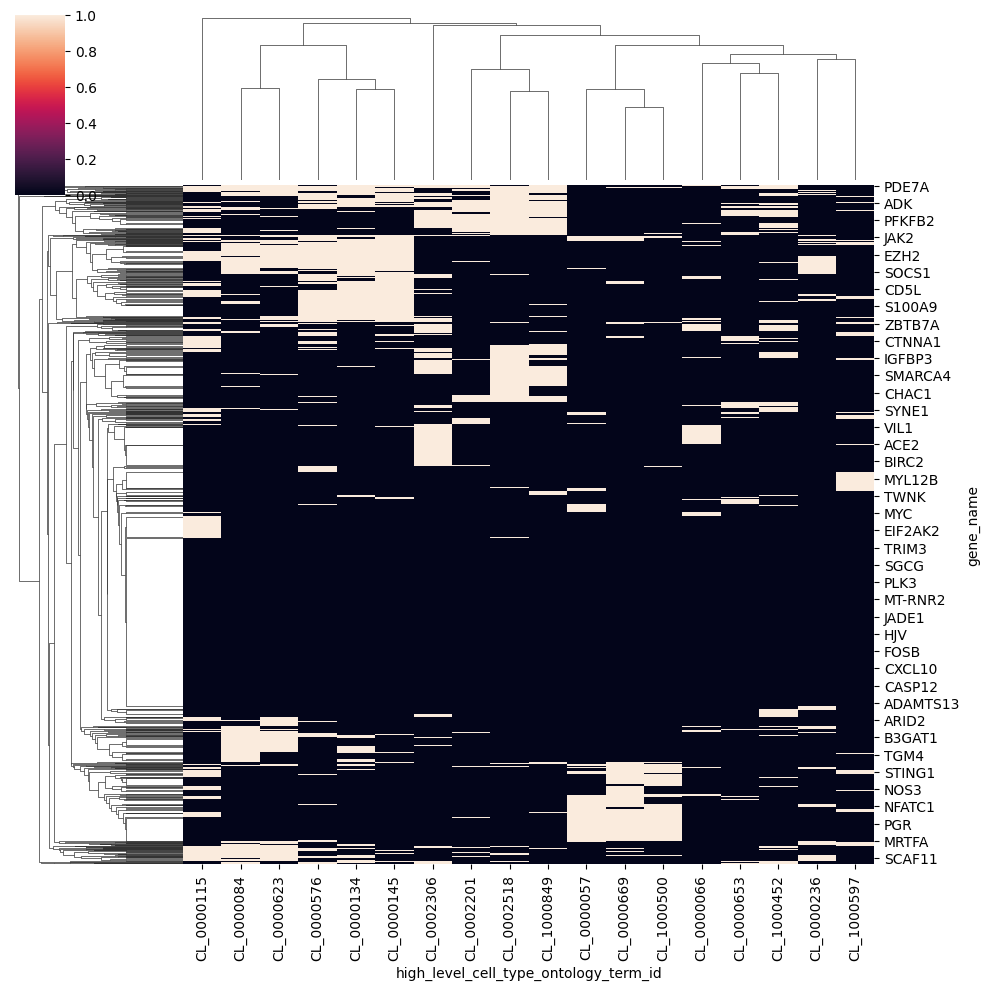

In [75]:
sns.clustermap(res)
plt.show()

In [98]:
celltype_de_results.to_csv(f'./data/DE_celltype_{disease_ontology_id.replace(":","_")}.drug_targets.csv')

### Test for DE disease

In [99]:
# Get clean disease label
pbulk_adata_test = pbulk_adata.copy()
pbulk_adata_test.obs['disease'] = ["_".join(x) for x in pbulk_adata_test.obs['disease'].str.split(" ")]
disease_term = pbulk_adata_test.obs['disease'][pbulk_adata_test.obs['disease'] !='normal'].unique()[0]

# pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'] = pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'].str.replace(":", "_").astype('category')
# ct_categories = pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'].cat.categories.tolist()

pbulk_adata_test.obs['disease'] = pbulk_adata_test.obs['disease'].astype('category').cat.reorder_categories(['normal', disease_term])

# Test DE between disease and healthy in cell types
disease_de_results = pd.DataFrame()
for ct_term in pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'].unique():
    ad_test = pbulk_adata_test[pbulk_adata_test.obs['high_level_cell_type_ontology_term_id'] == ct_term].copy()
    if ad_test.obs['disease'].unique().shape[0] >= 2:
        DE_design = '~' 
        for c in ['assay', 'suspension_type']:
            if ad_test.obs[c].nunique() > 1:
                DE_design = DE_design + c + " + "

        DE_design = DE_design + 'disease'

        de_results = run_glmGamPoi_DE(
            ad_test,
            design = DE_design,
            ref_level = 'normal',
            contrast = f'disease{disease_term}'
            )
        de_results['high_level_cell_type_ontology_term_id'] = ct_term
        disease_de_results = pd.concat([disease_de_results, de_results], axis=0)

# Test DE in "simulated bulk" - aggregating all cell types
pbulk_adata_test.obs['total_counts'] = pbulk_adata_test.obs['size_factors'].values
bulk_adata_test = anndata2pseudobulk(pbulk_adata_test, group_by=['donor_id', 'disease', 'assay', 'suspension_type'], agg='s')

bulk_de_results = run_glmGamPoi_DE(
            bulk_adata_test,
            design = '~ disease',
            ref_level = 'normal',
            contrast = f'disease{disease_term}'
            )

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/tmp/ipykernel_241/3838258468.py:61: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  de_res_df.drop('name', 1, inplace=True)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/tmp/ipykernel_241/3838258468.py:61: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  de_res_df.drop('name', 1, inplace=True)
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pa

In [100]:
disease_de_results['signif'] = (disease_de_results['adj_pval'] < 0.01) & (disease_de_results.lfc > 0)
res = disease_de_results.pivot(index='gene_name', columns='high_level_cell_type_ontology_term_id', values='signif')
res = res.fillna(0)

In [84]:
sns.clustermap(res)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


In [101]:
disease_de_results.to_csv(f'./data/DE_disease_{disease_ontology_id.replace(":","_")}.drug_targets.csv')
bulk_de_results.to_csv(f'./data/DE_bulk_{disease_ontology_id.replace(":","_")}.drug_targets.csv')

In [85]:
# disease_de_results.to_csv(f'./data/DE_disease_{disease_ontology_id.replace(":","_")}.all_targets.csv')
# bulk_de_results.to_csv(f'./data/DE_bulk_{disease_ontology_id.replace(":","_")}.all_targets.csv')

## Transform DE results to "evidence"

In [69]:
signif_thresh = 0.01

# Are the target genes cell type markers (significantly over-expressed in a subset of cell types)
ct_specificity_evidence_targets = celltype_de_results[(celltype_de_results['pval'] < signif_thresh) & (celltype_de_results['lfc'] > 0)].gene_name.unique()

In [418]:
# Are the target genes differentially expressed between disease and control in a subset of cell types (and not detectable in bulk)?
disease_ct_specificity_evidence_targets = disease_de_results[(disease_de_results['pval'] < signif_thresh)].gene_name.unique()

# Make 2 classes (comparison w results you might get from bulk RNA-seq)
disease_ct_specificity_evidence_targets = disease_ct_specificity_evidence_targets[bulk_de_results.loc[disease_ct_specificity_evidence_targets]['pval'] >= signif_thresh]

## Merge with OT evidence table

In [ ]:
# ...

In [70]:
name2id = dict(zip(pbulk_adata.var['feature_name'], pbulk_adata.var['feature_id']))
ct_specificity_evidence_targets = [name2id[x] for x in ct_specificity_evidence_targets]

In [71]:
disease_ct_specificity_evidence_targets = [name2id[x] for x in disease_ct_specificity_evidence_targets]

NameError: name 'disease_ct_specificity_evidence_targets' is not defined

In [72]:
targets = all_targets

,symbol,overallAssociationScore,geneticAssociations,somaticMutations,drugs,pathwaysSystemsBiology,textMining,rnaExpression,animalModels,targetName,targetId,diseaseId,has_cellxgene_disease_ontology
0,SERPINC1,0.395335,No data,No data,0.607930797611621,No data,0.8473198161877095,No data,No data,serpin family C member 1,ENSG00000117601,MONDO_0002492,True
1,SERPINC1,0.395335,No data,No data,0.607930797611621,No data,0.8473198161877095,No data,No data,serpin family C member 1,LRG_577,MONDO_0002492,True
2,PTGER1,0.370504,No data,No data,0.607930797611621,No data,0.030396539880581056,No data,No data,prostaglandin E receptor 1,ENSG00000160951,MONDO_0002492,True
3,PTGIR,0.369580,No data,No data,0.607930797611621,No data,No data,No data,No data,prostaglandin I2 receptor,ENSG00000160013,MONDO_0002492,True
4,ADRB1,0.369580,No data,No data,0.607930797611621,No data,No data,No data,No data,adrenoceptor beta 1,ENSG00000043591,MONDO_0002492,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,NDUFAF1,0.001478,No data,No data,No data,No data,0.012158615952232422,No data,No data,NADH:ubiquinone oxidoreductase complex assembl...,ENSG00000137806,MONDO_0002492,True
2151,LMNB1,0.001478,No data,No data,No data,No data,0.012158615952232422,No data,No data,lamin B1,ENSG00000113368,MONDO_0002492,True
2152,AREG,0.001478,No data,No data,No data,No data,0.012158615952232422,No data,No data,amphiregulin,ENSG00000109321,MONDO_0002492,True
2153,CRK,0.001478,No data,No data,No data,No data,0.012158615952232422,No data,No data,"CRK proto-oncogene, adaptor protein",ENSG00000167193,MONDO_0002492,True


In [427]:
disease_targets_df = targets[targets.diseaseId == disease_ontology_id.replace(":", "_")].copy()
disease_targets_df['is_successful'] = disease_targets_df['known_drug'] >= 0.2
disease_targets_df['is_ct_specific'] = disease_targets_df.targetId.isin(ct_specificity_evidence_targets)
disease_targets_df['is_disease_specific'] = disease_targets_df.targetId.isin(disease_ct_specificity_evidence_targets)

In [428]:
cont = pd.crosstab(disease_targets_df.is_ct_specific, disease_targets_df.is_successful)
print(cont)
scipy.stats.fisher_exact(cont)

is_successful   False  True 
is_ct_specific              
False               0      1
True                3      4


SignificanceResult(statistic=0.0, pvalue=1.0)

In [434]:
cont = pd.crosstab(disease_targets_df.is_disease_specific, disease_targets_df.is_successful).T
print(cont)
scipy.stats.fisher_exact(cont, alternative='greater')

is_disease_specific  False  True 
is_successful                    
False                    0      3
True                     2      3


SignificanceResult(statistic=0.0, pvalue=1.0)

In [458]:
cont = np.array([[2,1],[1,12]])
cont

array([[ 2,  1],
       [ 1, 12]])

In [459]:
scipy.stats.fisher_exact(cont)

SignificanceResult(statistic=24.0, pvalue=0.07142857142857141)

### Questions

- Assay: do we include all assays or just 10X?
- How to do multiple testing correction here? Across all celltypes? Across cell types and disease?
- Should the disease-specific test differentiate between celltype and disease specific as opposed to differentially expressed across cell types?
- Should the disease-specific test consider just up-regulation?
- Should we test for DE in ALL OpenTargets targets? To use as a negative category for successful drugs, but still look at disease-relevant genes

## Compare DE results between testing on drug targets / all targets

In [319]:
ct_res_all = pd.read_csv('./data/DE_celltype_MONDO_0002492.all_targets.csv')
ct_res_drug = pd.read_csv('./data/DE_celltype_MONDO_0002492.drug_targets.csv')

ct_res_all.loc[ct_res_all.lfc > 10, 'lfc'] = 10
ct_res_all.loc[ct_res_all.lfc < -10, 'lfc'] = -10

ct_names_df = pbulk_adata.obs[['high_level_cell_type', 'high_level_cell_type_ontology_term_id']].drop_duplicates()
ct_names_df['high_level_cell_type_ontology_term_id'] = ct_names_df['high_level_cell_type_ontology_term_id'].str.replace(":", "_")

ct_res_all = pd.merge(ct_res_all, ct_names_df, on='high_level_cell_type_ontology_term_id')
ct_res_drug = pd.merge(ct_res_drug, ct_names_df, on='high_level_cell_type_ontology_term_id')
ct_res_all['log_adj_pval'] = - np.log10(ct_res_all['adj_pval'])
ct_res_all['is_drug_target'] = ct_res_all.gene_name.isin(ct_res_drug.gene_name.unique())

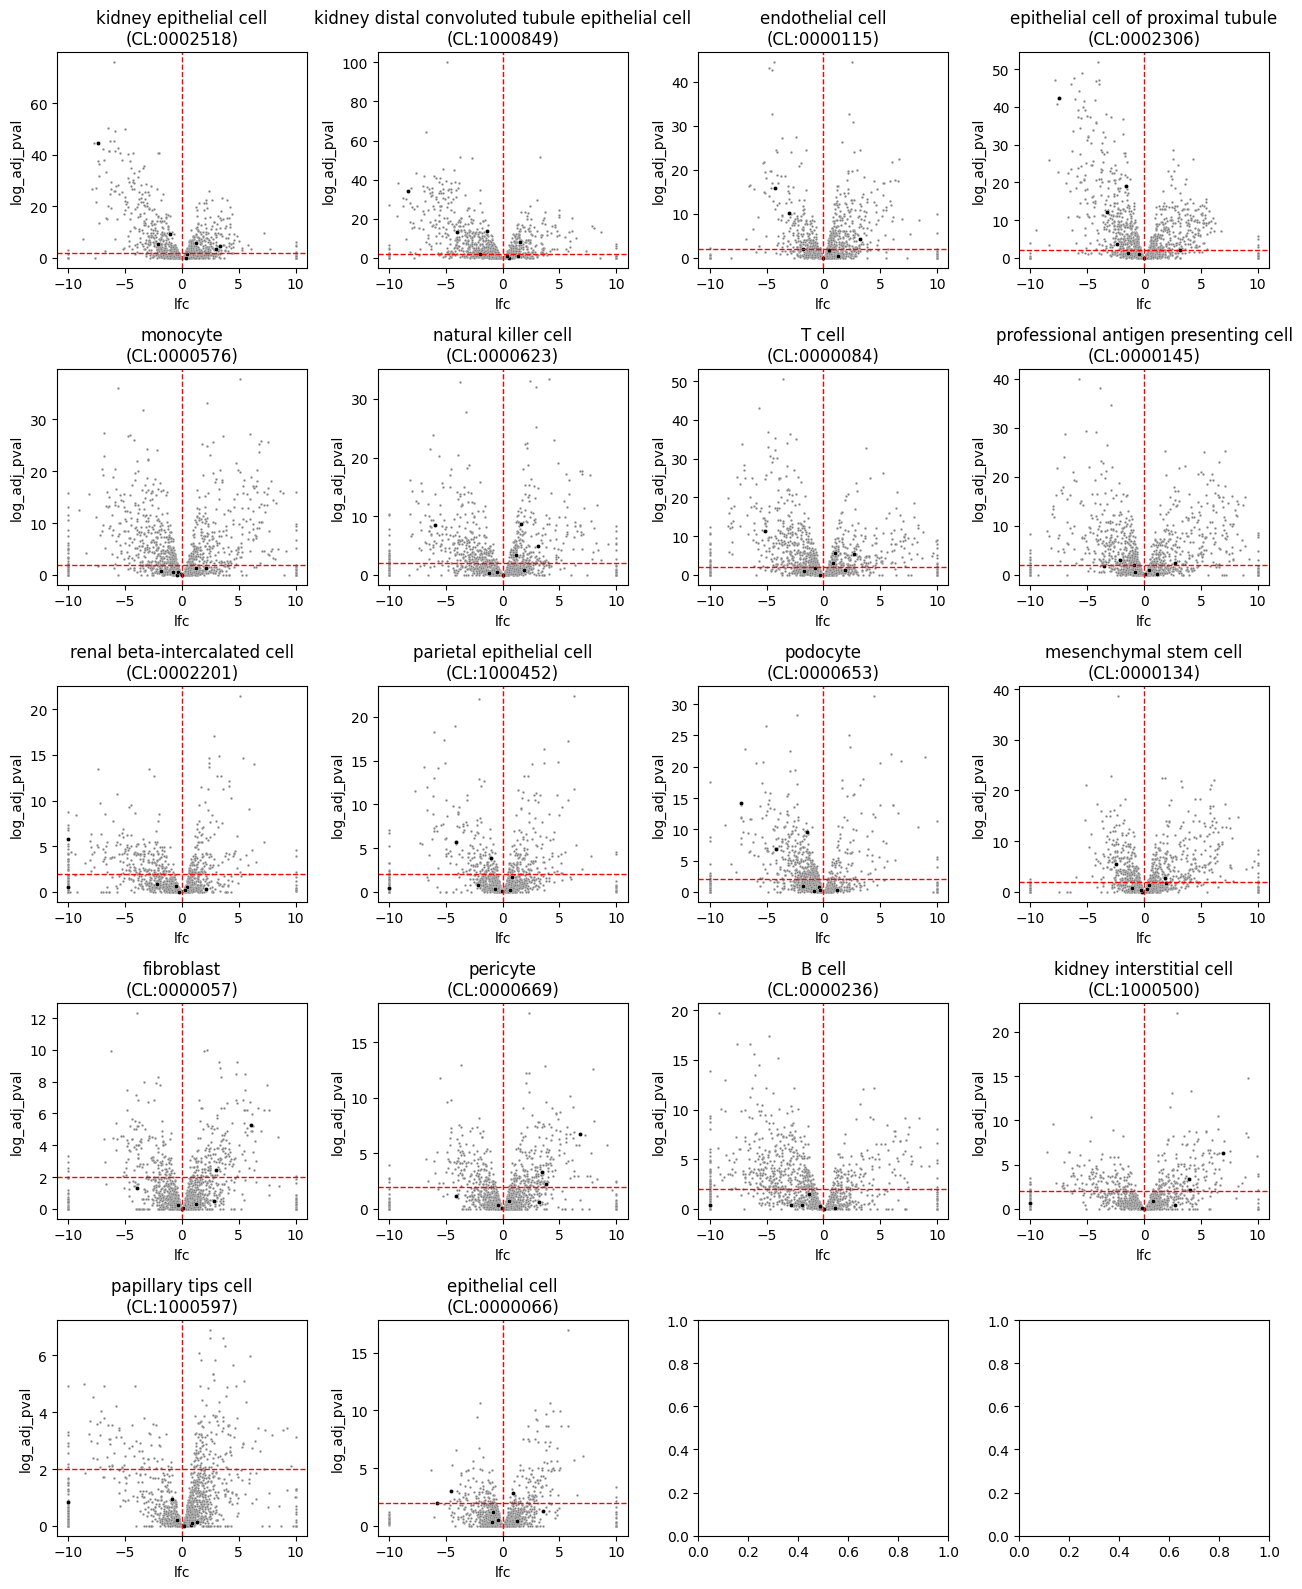

In [168]:

nrows = 5
ncols = 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13, 16))

for i, ct in enumerate(ct_res_all.high_level_cell_type.unique().tolist()):
    row_i, col_i = divmod(i, ncols)  # Calculate the row and column indices

    ax = axes[row_i, col_i]  # Get the corresponding subplot axis

    sns.scatterplot(data=ct_res_all[ct_res_all.high_level_cell_type == ct],
                    s=3, color='grey',
                    x='lfc', y='log_adj_pval', ax=ax)
    sns.scatterplot(data=ct_res_all[(ct_res_all.high_level_cell_type == ct) & (ct_res_all.is_drug_target)],
                    s=9, color='black',
                    x='lfc', y='log_adj_pval', ax=ax)

    ax.set_title(ct.replace(" (CL:", "\n(CL:"))
    ax.axvline(0, color='r', linewidth=1, linestyle='--')
    ax.axhline(2, color='r', linewidth=1, linestyle='--')

plt.tight_layout()  # Adjust subplot spacing
plt.show()

In [175]:
signif_thresh = 0.01

# Are the target genes cell type markers (significantly over-expressed in a subset of cell types)
ct_specificity_evidence_targets = ct_res_all[(ct_res_all['pval'] < signif_thresh) & (ct_res_all['lfc'] > 0)].gene_name.unique()

In [192]:
evidence_df = ct_res_all.groupby('gene_name').sum()[['signif', 'is_drug_target']]
evidence_df['has_ct_evidence'] = np.where(evidence_df['signif'] > 0, True, False)
evidence_df['is_drug_target'] = np.where(evidence_df['is_drug_target'] > 0, True, False)

/tmp/ipykernel_241/3491677202.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  evidence_df = ct_res_all.groupby('gene_name').sum()[['signif', 'is_drug_target']]


In [193]:
pd.crosstab(evidence_df['has_ct_evidence'], evidence_df['is_drug_target'])

is_drug_target,False,True
has_ct_evidence,,
False,409,0
True,1237,8


In [195]:
scipy.stats.fisher_exact(pd.crosstab(evidence_df['has_ct_evidence'], evidence_df['is_drug_target']).T)

SignificanceResult(statistic=inf, pvalue=0.21204235736487387)

In [196]:
evidence_df = ct_res_drug.groupby('gene_name').sum()[['signif']]
evidence_df['has_ct_evidence'] = np.where(evidence_df['signif'] > 0, True, False)
evidence_df['is_drug_target'] = True
pd.crosstab(evidence_df['has_ct_evidence'], evidence_df['is_drug_target'])

/tmp/ipykernel_241/3527556896.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  evidence_df = ct_res_drug.groupby('gene_name').sum()[['signif']]


is_drug_target,True
has_ct_evidence,
False,1
True,7


In [320]:
disease_res_all = pd.read_csv('./data/DE_disease_MONDO_0002492.all_targets.csv')
disease_res_drug = pd.read_csv('./data/DE_disease_MONDO_0002492.drug_targets.csv')

disease_res_all.loc[disease_res_all.lfc > 10, 'lfc'] = 10
disease_res_all.loc[disease_res_all.lfc < -10, 'lfc'] = -10
ct_names_df['high_level_cell_type_ontology_term_id'] = ct_names_df['high_level_cell_type_ontology_term_id'].str.replace("_", ":")

disease_res_all = pd.merge(disease_res_all, ct_names_df, on='high_level_cell_type_ontology_term_id')
disease_res_drug = pd.merge(disease_res_drug, ct_names_df, on='high_level_cell_type_ontology_term_id')

In [321]:
disease_res_all['signif'] = disease_res_all['adj_pval'] < 0.01

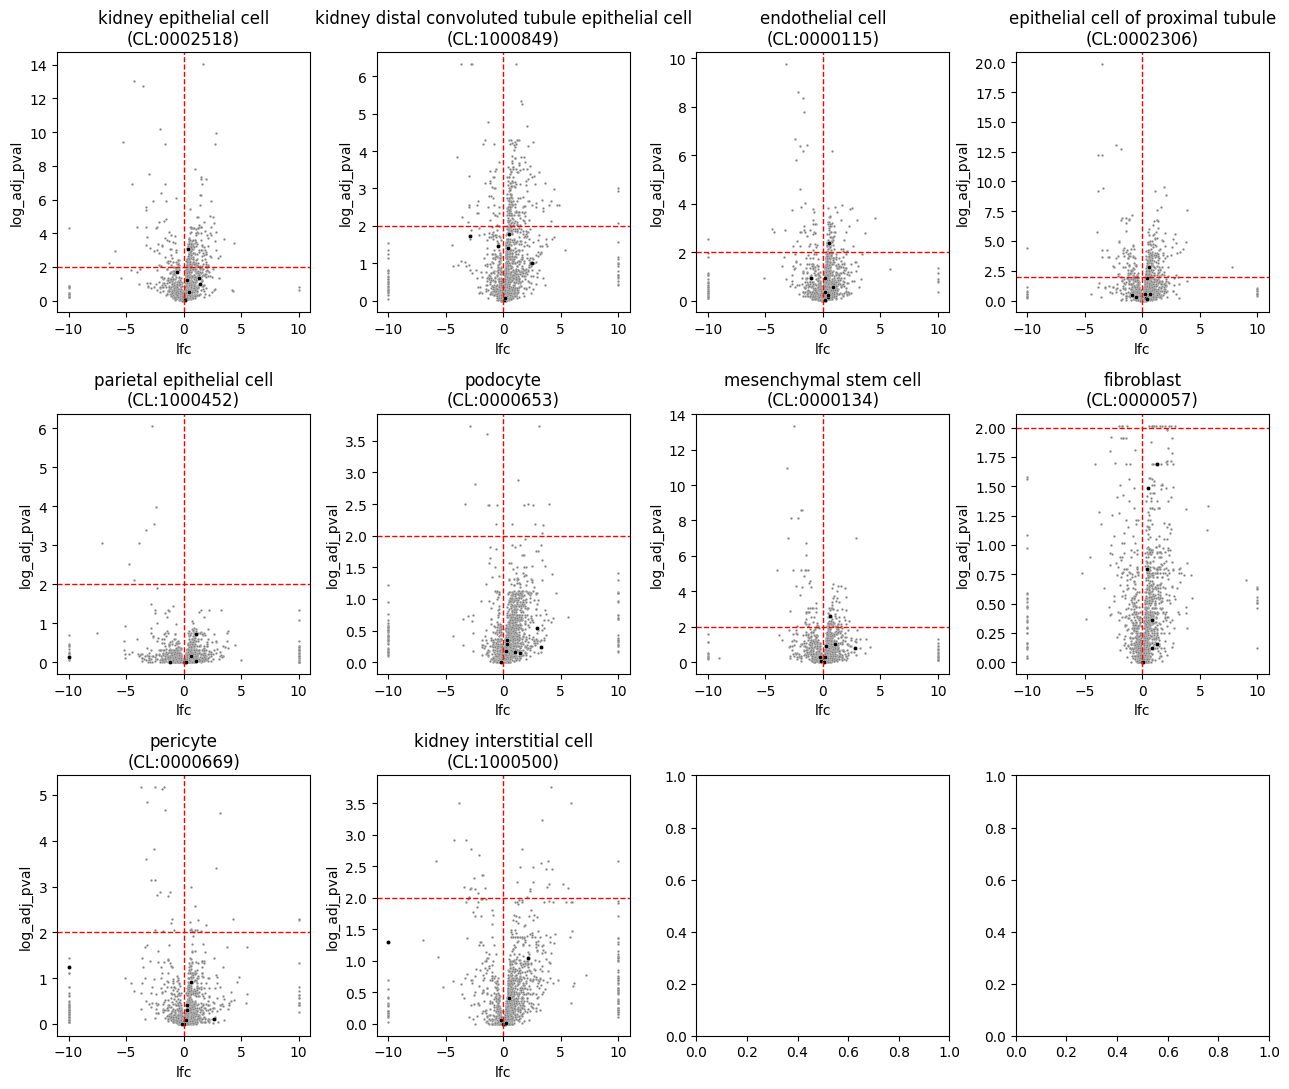

In [322]:
disease_res_all['log_adj_pval'] = - np.log10(disease_res_all['adj_pval'])
disease_res_all['is_drug_target'] = disease_res_all.gene_name.isin(ct_res_drug.gene_name.unique())

nrows = 3
ncols = 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13, 11))

for i, ct in enumerate(disease_res_all.high_level_cell_type.unique().tolist()):
    row_i, col_i = divmod(i, ncols)  # Calculate the row and column indices

    ax = axes[row_i, col_i]  # Get the corresponding subplot axis

    sns.scatterplot(data=disease_res_all[disease_res_all.high_level_cell_type == ct],
                    s=3, color='grey',
                    x='lfc', y='log_adj_pval', ax=ax)
    sns.scatterplot(data=disease_res_all[(disease_res_all.high_level_cell_type == ct) & (disease_res_all.is_drug_target)],
                    s=9, color='black',
                    x='lfc', y='log_adj_pval', ax=ax)

    ax.set_title(ct.replace(" (CL:", "\n(CL:"))
    ax.axvline(0, color='r', linewidth=1, linestyle='--')
    ax.axhline(2, color='r', linewidth=1, linestyle='--')

plt.tight_layout()  # Adjust subplot spacing
plt.show()

In [219]:
evidence_df = disease_res_all.groupby('gene_name').sum()[['signif', 'is_drug_target']]
evidence_df['has_disease_evidence'] = np.where(evidence_df['signif'] > 0, True, False)
evidence_df['is_drug_target'] = np.where(evidence_df['is_drug_target'] > 0, True, False)

/tmp/ipykernel_241/1319371618.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  evidence_df = disease_res_all.groupby('gene_name').sum()[['signif', 'is_drug_target']]


In [221]:
pd.crosstab(evidence_df['has_disease_evidence'], evidence_df['is_drug_target'])

is_drug_target,False,True
has_disease_evidence,,
False,1182,6
True,464,2


In [218]:
scipy.stats.fisher_exact(pd.crosstab(evidence_df['has_ct_evidence'], evidence_df['is_drug_target']).T)

SignificanceResult(statistic=0.8491379310344828, pvalue=1.0)

In [196]:
evidence_df = ct_res_drug.groupby('gene_name').sum()[['signif']]
evidence_df['has_ct_evidence'] = np.where(evidence_df['signif'] > 0, True, False)
evidence_df['is_drug_target'] = True
pd.crosstab(evidence_df['has_ct_evidence'], evidence_df['is_drug_target'])

/tmp/ipykernel_241/3527556896.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  evidence_df = ct_res_drug.groupby('gene_name').sum()[['signif']]


is_drug_target,True
has_ct_evidence,
False,1
True,7


In [248]:
%%R -i ct_res_all
head(ct_res_all)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


  gene_name         pval    adj_pval f_statistic df1      df2         lfc
0     NOC2L 0.0952292429 0.172897001  2.79521249   1 457.9925  0.23348905
1  TNFRSF14 0.8645738264 0.936297395  0.02912165   1 457.9925 -0.03979524
2     PARK7 0.3243194759 0.466456011  0.97354155   1 457.9925 -0.16524453
3    ERRFI1 0.0172573619 0.039208347  5.71151676   1 457.9925 -0.72542306
4      H6PD 0.0005156964 0.001600304 12.23166157   1 457.9925 -0.61825309
5    PIK3CD 0.0008229337 0.002465820 11.33907104   1 457.9925  0.93237672
  gene_name.1         gene_id high_level_cell_type_ontology_term_id signif
0       NOC2L ENSG00000188976                            CL_0002518  FALSE
1    TNFRSF14 ENSG00000157873                            CL_0002518  FALSE
2       PARK7 ENSG00000116288                            CL_0002518  FALSE
3      ERRFI1 ENSG00000116285                            CL_0002518  FALSE
4        H6PD ENSG00000049239                            CL_0002518  FALSE
5      PIK3CD ENSG00000171608   

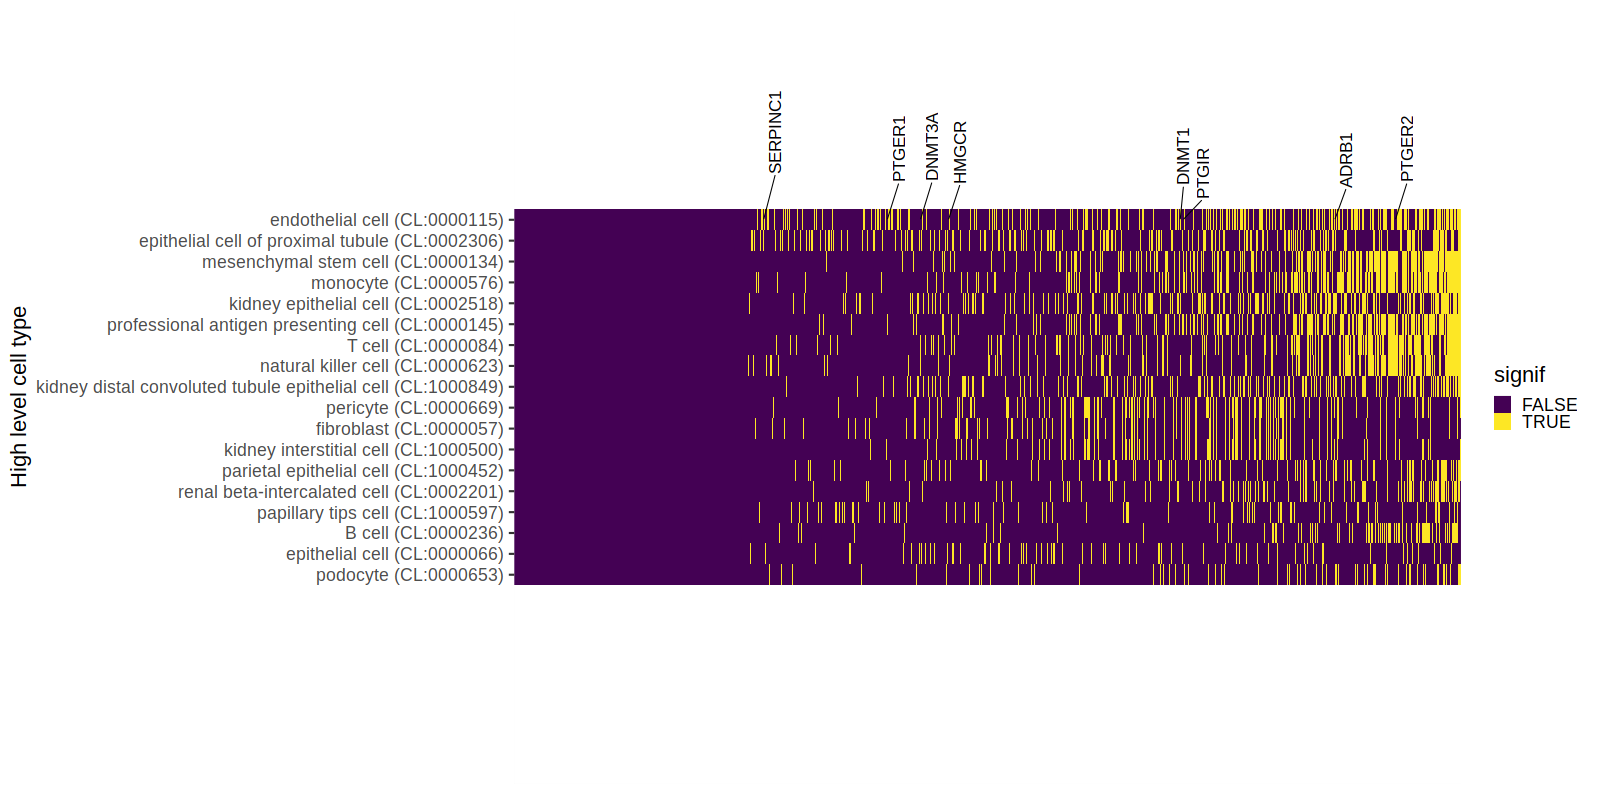

In [299]:
%%R -w 1600 -h 800
ct_res_all %>%
group_by(gene_name) %>%
mutate(n_signif = sum(signif)) %>%
ungroup() %>%
arrange(n_signif) %>%
mutate(gene_name = factor(gene_name, levels=unique(gene_name))) %>%
group_by(high_level_cell_type) %>%
mutate(n_signif = sum(signif)) %>%
ungroup() %>%
arrange(n_signif) %>%
mutate(high_level_cell_type = factor(high_level_cell_type, levels=unique(high_level_cell_type))) %>%
ggplot(aes(gene_name, high_level_cell_type, fill=signif)) +
geom_tile() +
ggrepel::geom_text_repel(data = . %>% filter(is_drug_target) %>% distinct(gene_name),  aes(label=gene_name, x=gene_name), inherit.aes=FALSE, y=18, size=6, angle=90, vjust=1, hjust=0) +
scale_y_discrete(expand = c(0, 10)) +
scale_fill_viridis_d() +
ylab('High level cell type') +
theme_grey(base_size=22) +
remove_x_axis() 

In [350]:
bulk_disease_res_all = pd.read_csv('./data/DE_bulk_MONDO_0002492.all_targets.csv')
bulk_disease_res_all['signif'] = bulk_disease_res_all.adj_pval < 0.01

bulk_disease_res_all['high_level_cell_type'] = 'bulk'
bulk_disease_res_all['is_drug_target'] = bulk_disease_res_all.gene_name.isin(ct_res_drug.gene_name.unique())

In [351]:
%%R -i disease_res_all -i bulk_disease_res_all
head(disease_res_all)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


  gene_name         pval     adj_pval f_statistic df1      df2        lfc
0     NOC2L 1.161508e-02 4.203712e-02    6.628881   1 92.82842  0.1861288
1  TNFRSF14 2.988566e-02 8.656896e-02    4.864384   1 92.82842  0.3814702
2     PARK7 1.081638e-02 4.047577e-02    6.765276   1 92.82842  0.3457713
3    ERRFI1 3.978201e-09 3.870555e-07   42.243232   1 92.82842 -1.9314531
4      H6PD 1.093496e-02 4.060290e-02    6.744372   1 92.82842  0.2543588
5    PIK3CD 7.646925e-03 3.130697e-02    7.435296   1 92.82842  0.4171735
  gene_name.1         gene_id high_level_cell_type_ontology_term_id signif
0       NOC2L ENSG00000188976                            CL:0002518  FALSE
1    TNFRSF14 ENSG00000157873                            CL:0002518  FALSE
2       PARK7 ENSG00000116288                            CL:0002518  FALSE
3      ERRFI1 ENSG00000116285                            CL:0002518   TRUE
4        H6PD ENSG00000049239                            CL:0002518  FALSE
5      PIK3CD ENSG00000171608   

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


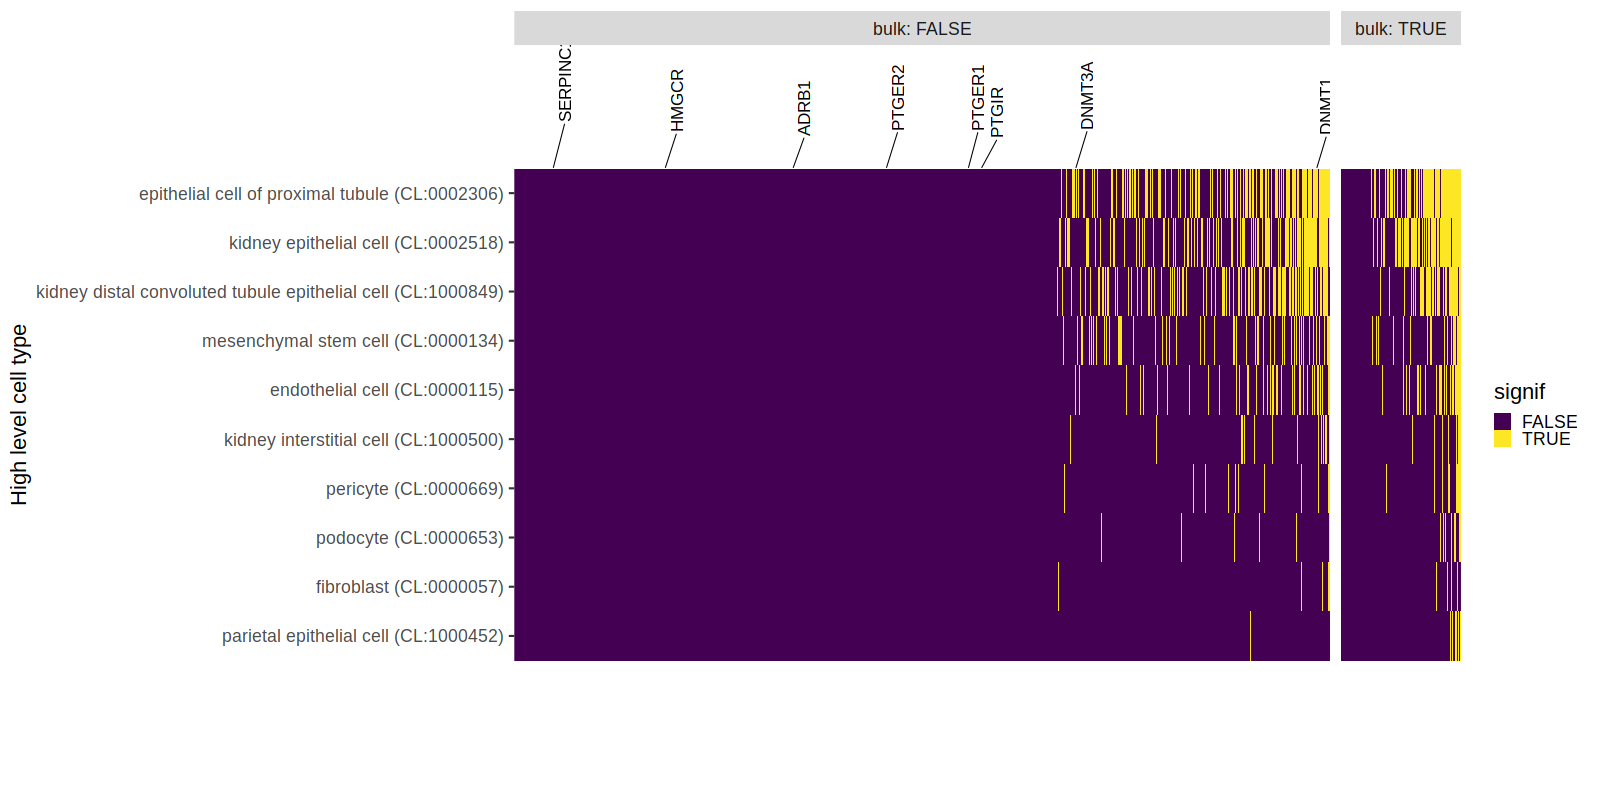

In [364]:
%%R -w 1600 -h 800
bind_rows(disease_res_all, bulk_disease_res_all) %>%
distinct(gene_name, is_drug_target, signif, high_level_cell_type) %>%
pivot_wider(id_cols=c(gene_name, is_drug_target), values_from = signif, names_from=high_level_cell_type) %>%
pivot_longer(cols=unique(disease_res_all$high_level_cell_type), values_to = 'signif', names_to = 'high_level_cell_type') %>% 
group_by(gene_name) %>%
mutate(n_signif = sum(signif)) %>%
ungroup() %>%
arrange(n_signif) %>%
mutate(gene_name = factor(gene_name, levels=unique(gene_name))) %>%
group_by(high_level_cell_type) %>%
mutate(n_signif = sum(signif)) %>%
ungroup() %>%
arrange(n_signif) %>%
mutate(high_level_cell_type = factor(high_level_cell_type, levels=unique(high_level_cell_type))) %>%
# filter(bulk & is_drug_target)
ggplot(aes(gene_name, high_level_cell_type, fill=signif)) +
geom_tile() +
ggrepel::geom_text_repel(data = . %>% filter(is_drug_target) %>% distinct(gene_name, bulk),  aes(label=as.character(gene_name), x=as.character(gene_name)), 
                         inherit.aes=FALSE, y=10.5, size=6, angle=90, vjust=1, hjust=0) +
scale_y_discrete(expand = c(0, 3)) +
scale_fill_viridis_d() +
facet_grid(.~bulk, space='free', scales='free', labeller='label_both') +
ylab('High level cell type') +
theme_grey(base_size=22) +
remove_x_axis() 

In [252]:
%%R


 [1] "8"    "7"    "3"    "5"    "11"   "12"   "2"    "17"   "18"   "14"  
[11] "16"   "10"   "6"    "15"   "1"    "9"    "13"   "4"    "ciao"
